# Network Architecture

## Feature Learning

In [1]:
# import os
# import tensorflow as tf
# from tensorflow.keras.layers import Conv2D, ZeroPadding2D
# from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
# from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.losses import categorical_crossentropy
# from tensorflow.keras.optimizers import Adadelta
# from tensorflow.keras import backend as K
import keras
from keras.layers import Conv2D, ZeroPadding2D
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from keras import backend as K
from torch.nn import Conv2d
import matplotlib.pyplot as plt
from src import utils


# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Using TensorFlow backend.


### Convolution Layer

Takes input image $x_\text{in}$ and applies a kernel function $\Omega$, such that,

$$x_\text{out} = \Omega(x_\text{in})\tag{1}$$

where the output image $x_\text{out}$ is the result of convolution using kernel function $\Omega$ and the input image $x_\text{in}$. The dimensions of $x_\text{out} \in \mathbb{R}^{W_\text{out} \times H_\text{out} \times D_\text{out}}$ are dependent on the dimensions of $x_\text{in} \in \mathbb{R}^{W_\text{in} \times H_\text{in} \times D_\text{in}}$ and the hyperparameters of the kernel function $\Omega$: the number of kernels $K$, kernel size $F$, the stride $S$, and the amount of padding $P$.

$$x_\text{in} \in \mathbb{R}^{W_\text{in} \times H_\text{in} \times D_\text{in}} \quad\overset{\Omega}{\longrightarrow}\quad x_\text{out} \in \mathbb{R}^{W_\text{out} \times H_\text{out} \times D_\text{out}}$$

where

$$W_\text{out} = \frac{W_\text{in} - F + 2P}{S} + 1\tag{2}$$

$$H_\text{out} = \frac{H_\text{in} - F + 2P}{S} + 1\tag{3}$$

$$D_\text{out} = K\tag{4}$$

For example, let $x_\text{in} \in \mathbb{R}^{5 \times 5 \times 1}$ and the kernel filter $\omega \in \mathbb{R}^{3 \times 3}$. We compute the dimensions of the $x_\text{out}$ resuting from convolution of $x_\text{in}$ and $\omega$ using stride $S=1$ and no padding $P=0$ as follows:

$$W_\text{out} = \frac{W_\text{in} - F + 2P}{S} + 1 = \frac{5 - 3 + 2(0)}{1} + 1 = 3$$

$$H_\text{out} = \frac{H_\text{in} - F + 2P}{S} + 1 = \frac{5 - 3 + 2(0)}{1} + 1 = 3$$

$$D_\text{out} = K = 1$$

Therefore, $x_\text{out} \in \mathbb{R}^{3 \times 3 \times 1}$.

Further information about specific kernels and a more in-depth introduction to convolution can be found in the `image_processing` repository.

We load an image $x \in \mathbb{R}^{28 \times 28 \times 1}$ from the MNIST dataset below.

In [2]:
x = utils.Load(method='torch').mnist(sample=9)

torch.Size([1, 1, 28, 28])


Note that PyTorch documentation specifies an input tensor of the form $(N, C_\text{in}, H_\text{in}, W_\text{in})$, where $N$ is the batch size, $C_\text{in}$ is the number of channels ($C_\text{in}=1$ for grayscale image and $C_\text{in}=3$ for RGB images), $H_\text{in}$ is the number of rows (in pixels), and $W_\text{in}$ is the number of columns (in pixels).

Using the PyTorch `Conv2d` function, we create two convolution objects, `conv1` and `conv2`. The first convolution object `conv1` uses 6 kernel filters ($K=6$) and no padding ($P=0$), while `conv2` uses 12 kernel filters ($K=12$) and adds zero padding ($P=1$). Both convolution objects have kernel size $F=3$ and stride $S=1$, in addition to the number of input channels being 1 (since $D_\text{in} = 1$).

In [3]:
conv1 = Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=0)

In [4]:
conv2 = Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1)

Convolution of the image and the random kernels is as follows:

In [5]:
x1 = conv1(x).detach().numpy()
x2 = conv2(x).detach().numpy()

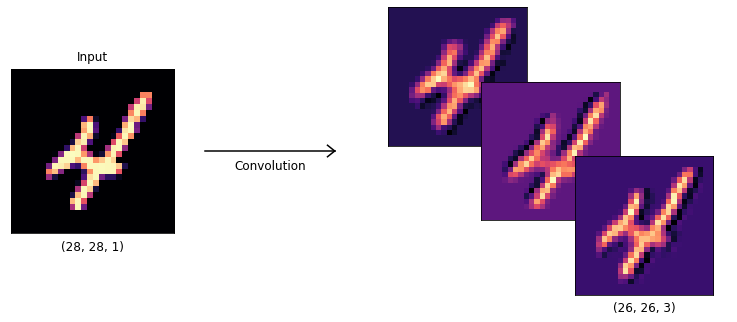

In [6]:
utils.Plot().network(x, [x1])

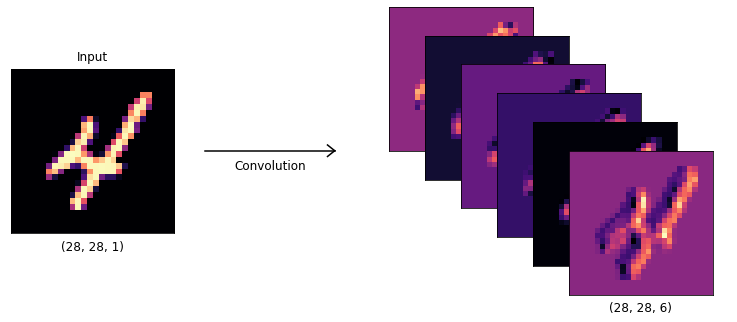

In [7]:
utils.Plot().network(x, [x2])

### Activation Layer

We use activation functions to increase non-linearity in the network. In theory, applying an activation function to convolutional layers is similar to biological action potential thresholding in the firing of neurons.

#### Rectified Linear Unit  (ReLU)
$$f(x) = \begin{cases} 0 & \text{for } x \leq 0 \\
x & \text{for } x > 0 \end{cases}$$

Here we provide an example of convolution with ReLU activation using Keras. By default, Keras requires an input tensor of the form $(N, H_\text{in}, W_\text{in}, C_\text{in})$, which is known as *channels last* format. We load the same MNIST image in *channels last* format as follows:

In [8]:
x = utils.Load(method='keras').mnist(sample=9)

(1, 28, 28, 1)


In [9]:
pad = ZeroPadding2D(padding=(1,1))
relu1 = Conv2D(filters=3, kernel_size=3, strides=1, activation='relu')
relu2 = Conv2D(filters=6, kernel_size=3, strides=1, activation='relu')

In [10]:
x1 = relu1(x)
x2 = relu2(pad(x))

We convert the tensors to numpy arrays for plotting as follows:

In [11]:
x1 = K.eval(x1)
x2 = K.eval(x2)

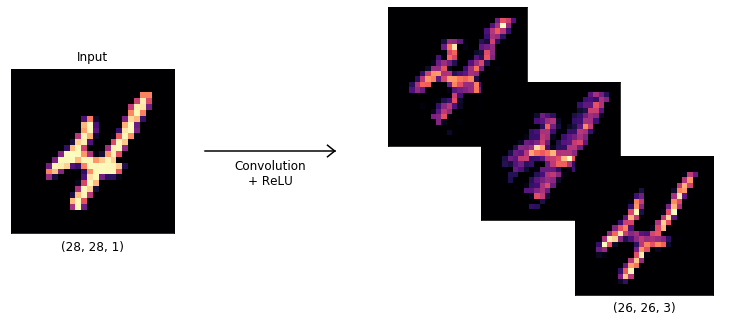

In [12]:
utils.Plot().network(x, [x1], activation='ReLU', channels='last')

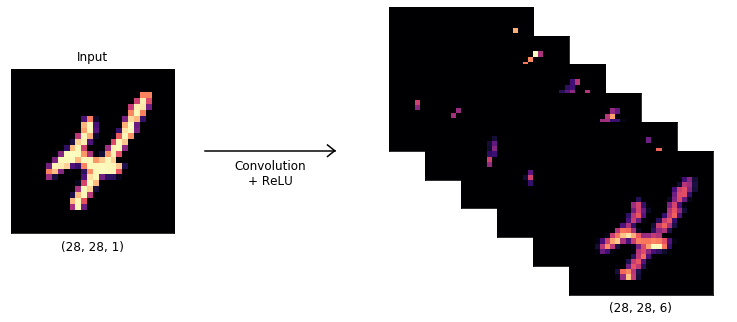

In [13]:
utils.Plot().network(x, [x2], activation='ReLU', channels='last')

#### Sigmoid
$$f(x) = \sigma(x) = \frac{1}{1 + e^{-x}}$$

In [14]:
def display_conv(x, conv, activation):
    x1 = K.eval(conv(x))
    utils.Plot().network(x, [x1], activation=activation, channels='last')
    return None

In [15]:
sigmoid = Conv2D(filters=3, kernel_size=3, strides=1, activation='sigmoid')

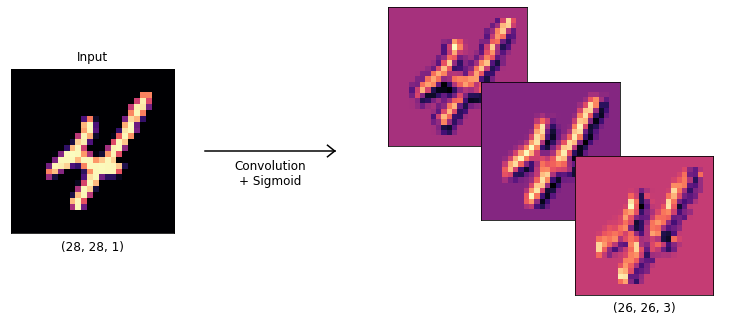

In [16]:
display_conv(x, sigmoid, activation='Sigmoid')

#### Hyperbolic Tangent (tanh)
$$f(x) = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

In [17]:
tanh = Conv2D(filters=3, kernel_size=3, strides=1, activation='tanh')

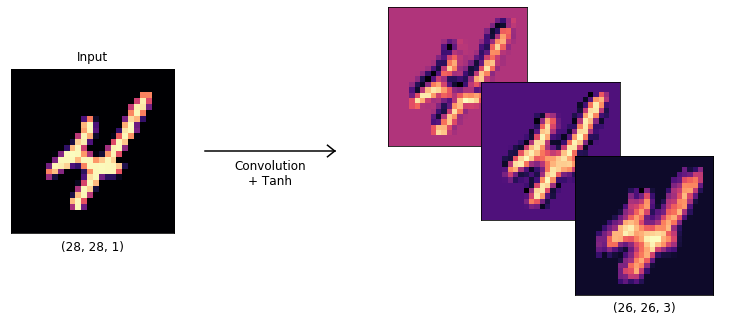

In [18]:
display_conv(x, tanh, activation='Tanh')

#### Softmax
$$P(y=j| \mathbf{x}) = \frac{e^{\mathbf{x}^\mathsf{T}\mathbf{w}_j}}{\sum_{k=1}^{k} e^{\mathbf{x}^\mathsf{T}\mathbf{w}_k}}$$

In [19]:
softmax = Conv2D(filters=3, kernel_size=3, strides=1, activation='softmax')

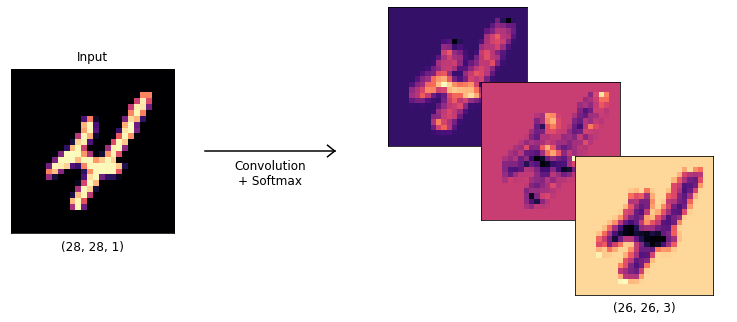

In [20]:
display_conv(x, softmax, activation='Softmax')

#### Exponential Linear Unit (ELU)
$$f(\alpha, x) = \begin{cases} \alpha (e^x - 1) & \text{for } x \leq 0 \\
x & \text{for } x > 0 \end{cases}$$

In [21]:
elu = Conv2D(filters=3, kernel_size=3, strides=1, activation='elu')

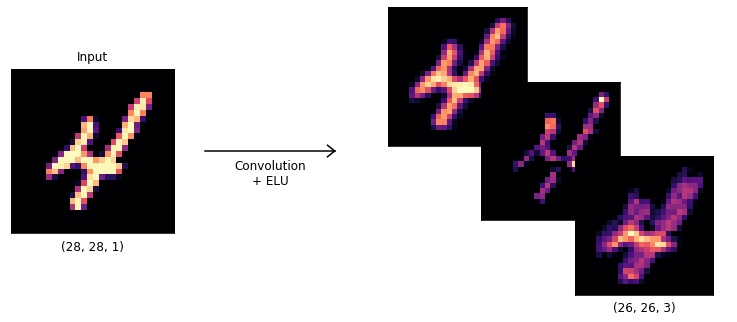

In [22]:
display_conv(x, elu, activation='ELU')

#### Softplus
$$f(x) = \ln(1 + e^x)$$

In [23]:
softplus = Conv2D(filters=3, kernel_size=3, strides=1, activation='softplus')

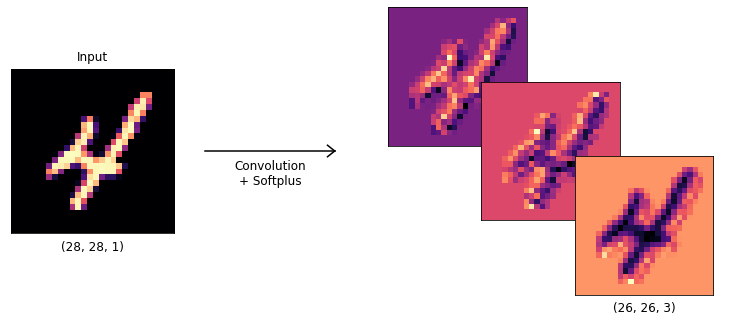

In [24]:
display_conv(x, softplus, activation='Softplus')

#### Softsign
$$f(x) = \frac{x}{1 + |x|}$$

In [25]:
softsign = Conv2D(filters=3, kernel_size=3, strides=1, activation='softsign')

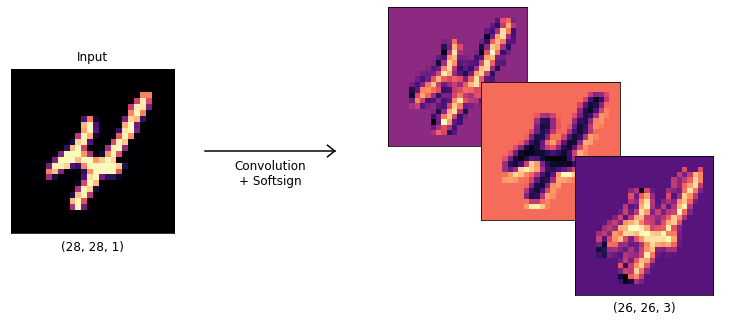

In [26]:
display_conv(x, softsign, activation='Softsign')

#### Others

- Leaky ReLU

- PReLU

- RReLU

- SELU

- GELU

### Pooling Layer

#### Max Pooling

In [27]:
def display_conv_pool(x, conv_list, network_id):
    x_list = [conv_list[0](x)]
    for i in range(1, len(conv_list)):
        x_list += [conv_list[i](x_list[i-1])]
    x_list = [K.eval(x_list[i]) for i in range(len(conv_list))]
    utils.Plot(height=5).network(x, x_list, network_id=network_id,
                                 channels='last')
    return None

In [28]:
relu = Conv2D(filters=6, kernel_size=3, strides=1, activation='relu')
maxpool = MaxPooling2D(pool_size=(2, 2))

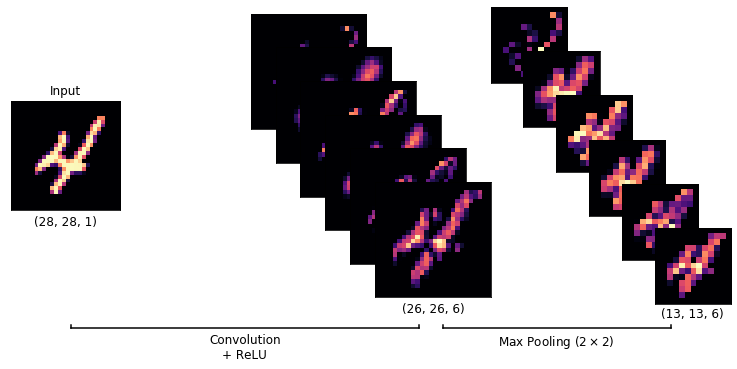

In [29]:
display_conv_pool(x, [relu, maxpool], network_id=0)

In [30]:
softmax = Conv2D(filters=6, kernel_size=3, strides=1, activation='softmax')

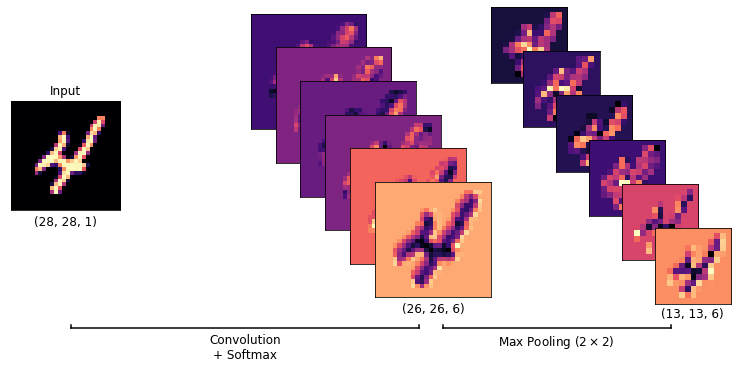

In [31]:
display_conv_pool(x, [softmax, maxpool], network_id=1)

#### Average Pooling

In [32]:
avgpool = AveragePooling2D(pool_size=(2, 2))

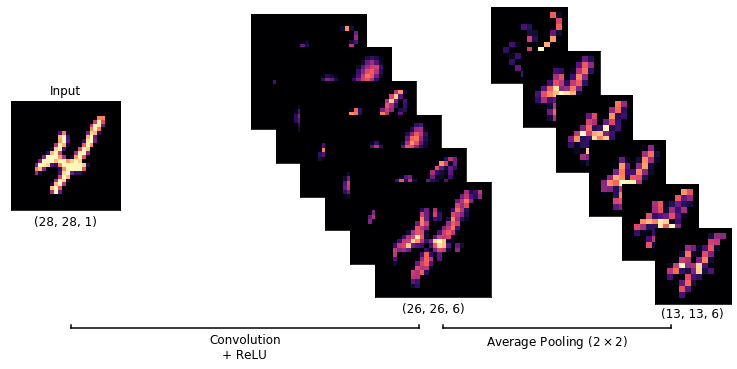

In [33]:
display_conv_pool(x, [relu, avgpool], network_id=2)

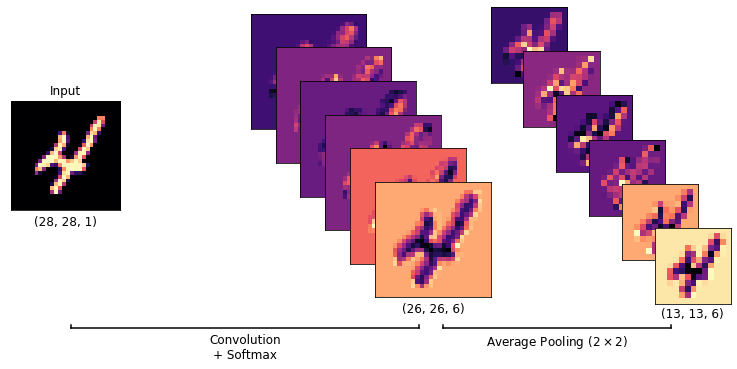

In [34]:
display_conv_pool(x, [softmax, avgpool], network_id=3)

In [35]:
softmax = Conv2D(filters=6, kernel_size=3, strides=1, activation='softmax')
relu = Conv2D(filters=6, kernel_size=3, strides=1, activation='relu')

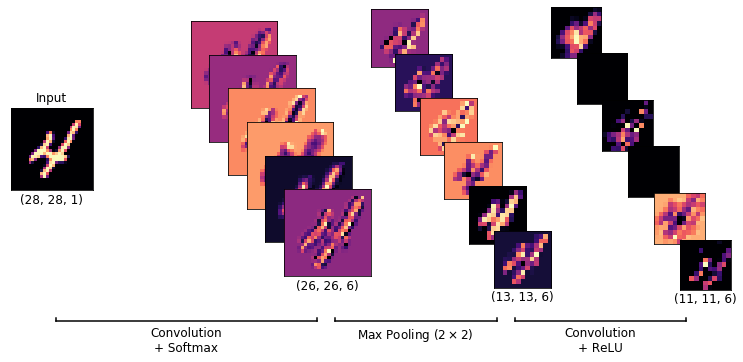

In [36]:
display_conv_pool(x, [softmax, maxpool, relu], network_id=4)

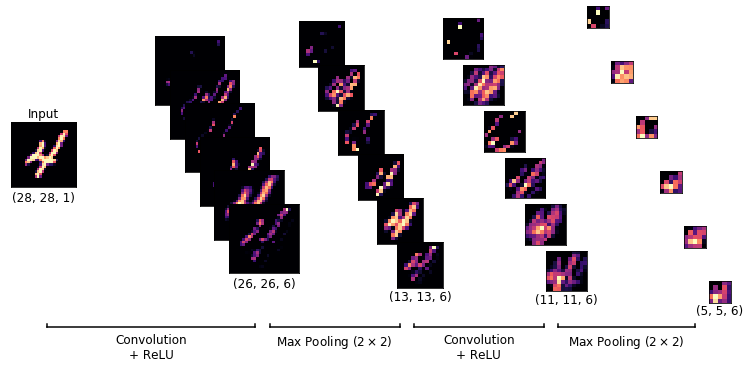

In [37]:
relu1 = Conv2D(filters=6, kernel_size=3, strides=1, activation='relu')
relu2 = Conv2D(filters=6, kernel_size=3, strides=1, activation='relu')
maxpool = MaxPooling2D(pool_size=(2, 2))
display_conv_pool(x, [relu1, maxpool, relu2, maxpool], network_id=5)

In [2]:
x_train, y_train, x_test, y_test, input_shape = utils.Load(method='keras').mnist()
x_train = K.eval(x_train)
y_train = K.eval(y_train)
x_test = K.eval(x_test)
y_test = K.eval(y_test)

## Classification

CNN model architecture is typically similar to that shown above, where we repeat convolution with ReLU activation and occasionally follow it up with max pooling to reduce dimensionality. These network levels are often referred to as the feature learning layers. After feature learning, we shift our focus to classification using fully connected (FC) layers.

### Fully Connected (FC) Layers

Here, we introduce FC layers by building a network beginning with feature learning. We initialize a Keras sequential model object as follows:

In [40]:
model = Sequential()

Beginning with the architecture

$$\underset{29 \times 29 \times 1}{ \ \textsf{input}^{+}} \ \ _{+ \ 3 \times 3\ \text{conv + ReLU} \ \ \longrightarrow} \ \ \underset{28 \times 28 \times 32}{\textsf{conv1}^\ddagger}  \ \ _{ + \ 1 \times 1 \ \text{pad} \ \ \longrightarrow} \ \ \underset{29 \times 29 \times 32}{\textsf{conv1}} \ \ _{+ \ 3 \times 3 \ \text{conv + ReLU}  \ \ \longrightarrow} \ \ \underset{28 \times 28 \times 64}{\textsf{conv2}}$$

we add layers as follows:

In [41]:
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(29, 29, 1)))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))

$$\underset{28 \times 28 \times 64}{\textsf{conv2}} \ \ _{ + \ 2 \times 2 \ \text{max pool} \ \ \longrightarrow} \ \ \underset{14 \times 14 \times 64}{\textsf{conv2}} \ \ _{ + \ 1 \times 1 \ \text{pad} \ \ \longrightarrow} \ \ \underset{15 \times 15 \times 64}{\textsf{conv2}} \ \ _{ + \ 3 \times 3 \ \text{conv + ReLU}  \ \ \longrightarrow} \ \ \underset{14 \times 14 \times 64}{\textsf{conv3}}$$

In [42]:
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))

$$\underset{14 \times 14 \times 64}{\textsf{conv3}} \ \ _{ + \ 2 \times 2 \ \text{max pool} \ \ \longrightarrow} \ \ \underset{7 \times 7 \times 64}{\textsf{conv3}} \ \ _{ + \ 3 \times 3 \ \text{conv + ReLU} \ \ \longrightarrow} \ \ \underset{5 \times 5 \times 64}{\textsf{conv4}}$$

In [43]:
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=3, activation='relu'))

Here we switch over to classification by vectorizing `conv5` as follows:

$$\underset{5 \times 5 \times 64}{\textsf{conv4}} \ \ _{ + \ \text{flatten} \ \ \longrightarrow} \ \ \underset{1600}{\textsf{FC1}} \ \ _{ + \ 400 \ \text{dense + ReLU} \ \ \longrightarrow} \ \ \underset{400}{\textsf{FC2}} \ \ _{ + \ 100 \ \text{dense + ReLU} \ \ \longrightarrow} \ \ \underset{100}{\textsf{FC3}} \ \ _{ + \ 10 \ \text{dense + Softmax} \ \ \longrightarrow} \ \ \underset{10}{\textsf{FC4}}$$

In [44]:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

As shown above, the final fully connected layer `FC3` is vector of length 10. Also note that the number of elements in the final layer should be equal to the number of classes we aim to predict (10 for the MNIST dataset).

In [45]:
model.compile(loss=categorical_crossentropy, optimizer=Adadelta(),
              metrics=['accuracy'])

In [47]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_train[50000:], y_train[50000:]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/12
50000/50000 [==============================] - 113s 2ms/step - loss: 0.0530 - accuracy: 0.9835 - val_loss: 0.0639 - val_accuracy: 0.9782
Epoch 2/12
50000/50000 [==============================] - 115s 2ms/step - loss: 0.0337 - accuracy: 0.9892 - val_loss: 0.0475 - val_accuracy: 0.9870
Epoch 3/12
50000/50000 [==============================] - 114s 2ms/step - loss: 0.0234 - accuracy: 0.9930 - val_loss: 0.0376 - val_accuracy: 0.9902
Epoch 4/12
50000/50000 [==============================] - 115s 2ms/step - loss: 0.0167 - accuracy: 0.9948 - val_loss: 0.0326 - val_accuracy: 0.9907
Epoch 5/12
50000/50000 [==============================] - 115s 2ms/step - loss: 0.0120 - accuracy: 0.9961 - val_loss: 0.0505 - val_accuracy: 0.9864
Epoch 6/12
50000/50000 [==============================] - 115s 2ms/step - loss: 0.0091 - accuracy: 0.9969 - val_loss: 0.0370 - val_accuracy: 0.9895
Epoch 7/12
50000/50000 [==============================] - 114s

In [48]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03586174809049949
Test accuracy: 0.9932000041007996


In [39]:
# x_train, y_train, x_test, y_test, input_shape = utils.Load(method='keras').mnist()
# x_train = K.eval(x_train)
# y_train = K.eval(y_train)
# x_test = K.eval(x_test)
# y_test = K.eval(y_test)

from keras.datasets import mnist

batch_size = 128
num_classes = 10
epochs = 2

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


0.25

In [4]:
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(29, 29, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [ ]:
# utils.fit(model, x_train, y_train, x_test, y_test)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5


In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 6

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/6
 3584/60000 [>.............................] - ETA: 1:16 - loss: 1.3037 - accuracy: 0.5731

KeyboardInterrupt: 

In [51]:
x1 = K.eval(model(x))

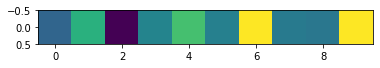

In [52]:
utils.Load(method='torch').mnist(sample=9)

In [45]:
import importlib
importlib.reload(utils)

<module 'src.utils' from '/Users/chadschupbach/projects/personal/mnist/src/utils.py'>

### Dropout

In [87]:
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential

True


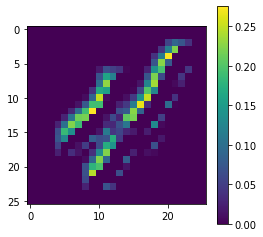

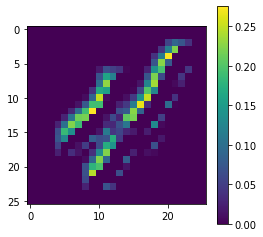

In [1639]:
relu = Conv2D(filters=6, kernel_size=3, activation='relu')
dropout = Dropout(0.5)
x1 = relu(x)
x2 = dropout(x1)
plt.figure(figsize=(4,4))
plt.imshow(K.eval(x1)[0,:,:,0])
plt.colorbar();
plt.figure(figsize=(4,4))
plt.imshow(K.eval(x2)[0,:,:,0])
plt.colorbar();
print(np.allclose(K.eval(x1), K.eval(x2)))
# display_conv_pool(x, , network_id=3)

In [1659]:
model = Sequential()
model.add(Conv2D(filters=3, kernel_size=3, activation='relu'))
x1 = keras.backend.eval(model(x))
print(x1.shape)
model.add(MaxPooling2D(pool_size=(2, 2)))
x2 = keras.backend.eval(model(x))
print(x2.shape)
model.add(Conv2D(filters=6, kernel_size=3, activation='relu'))
x3 = keras.backend.eval(model(x))
print(x3.shape)
model.add(MaxPooling2D(pool_size=(2, 2)))
x4 = keras.backend.eval(model(x))
print(x4.shape)
model.add(Conv2D(filters=6, kernel_size=3, activation='relu'))
x5 = keras.backend.eval(model(x))
print(x5.shape)
model.add(Flatten())
x6 = keras.backend.eval(model(x))
print(x6.shape)
model.add(Dense(32, activation='relu'))
x7 = keras.backend.eval(model(x))
print(x7.shape)

(1, 26, 26, 3)
(1, 13, 13, 3)
(1, 11, 11, 6)
(1, 5, 5, 6)
(1, 3, 3, 6)
(1, 54)
(1, 32)


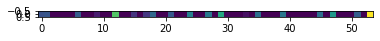

In [1657]:
plt.imshow(x6)

### Loss Layer

### Regularization